Introduction to the Sentiment Analysis Model using Ensemble Learning
This project focuses on sentiment analysis of customer reviews using an ensemble learning approach that combines Support Vector Machine (SVM) and Naïve Bayes classifiers. The model predicts whether a given review is Positive, Negative, or Neutral, helping businesses gain insights from customer feedback.

load dataset

In [1]:
import pandas as pd

# Load the new dataset
file_path = "C:/Users/kiran/OneDrive/Documents/personal/PROJECTS/OPINION MINING-S_N/tripadvisor_hotel_reviews.csv"  # Update with your actual file path
data = pd.read_csv(file_path)

# Display basic information
print("Dataset Loaded Successfully!")
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
print("First 5 Rows:\n", data.head())

Dataset Loaded Successfully!
Dataset Shape: (20491, 2)
Columns: Index(['Review', 'Rating'], dtype='object')
First 5 Rows:
                                               Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


Detailed information about your dataset

In [2]:
# Display dataset information
print("Dataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

# Display basic statistics
print("\nDataset Summary:\n", data.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None

Missing Values:
 Review    0
Rating    0
dtype: int64

Dataset Summary:
                                                    Review        Rating
count                                               20491  20491.000000
unique                                              20491           NaN
top     people talking, ca n't believe excellent ratin...           NaN
freq                                                    1           NaN
mean                                                  NaN      3.952223
std                                                   NaN      1.233030
min                                                   NaN      1.000000
25%                        

label sentiments based on the "Rating" column

In [3]:
# Function to classify ratings into sentiments
def label_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

# Apply the function to create a new column
data["Sentiment"] = data["Rating"].apply(label_sentiment)

# Display sentiment distribution
print("Sentiment Distribution:\n", data["Sentiment"].value_counts())

# Show updated dataset
print("\nUpdated Dataset Sample:\n", data.head())


Sentiment Distribution:
 Sentiment
Positive    15093
Negative     3214
Neutral      2184
Name: count, dtype: int64

Updated Dataset Sample:
                                               Review  Rating Sentiment
0  nice hotel expensive parking got good deal sta...       4  Positive
1  ok nothing special charge diamond member hilto...       2  Negative
2  nice rooms not 4* experience hotel monaco seat...       3   Neutral
3  unique, great stay, wonderful time hotel monac...       5  Positive
4  great stay great stay, went seahawk game aweso...       5  Positive


Cleaning the Reviews

In [4]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already available
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # Remove special characters and numbers
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning function
data["Cleaned_Review"] = data["Review"].apply(clean_text)

# Show sample cleaned reviews
print("Cleaned Reviews:\n", data[["Cleaned_Review", "Sentiment"]].head())

# Save the cleaned data
data.to_csv("cleaned_reviews.csv", index=False)
print("Cleaned dataset saved as 'cleaned_reviews.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiran\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Cleaned Reviews:
                                       Cleaned_Review Sentiment
0  nice hotel expensive parking got good deal sta...  Positive
1  ok nothing special charge diamond member hilto...  Negative
2  nice rooms experience hotel monaco seattle goo...   Neutral
3  unique great stay wonderful time hotel monaco ...  Positive
4  great stay great stay went seahawk game awesom...  Positive
Cleaned dataset saved as 'cleaned_reviews.csv'


TF-IDF Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Convert text to a matrix of TF-IDF features

# Fit and transform the cleaned reviews
X = tfidf_vectorizer.fit_transform(data["Cleaned_Review"])

# Save the TF-IDF vectorizer for future use
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf_vectorizer, file)

print("TF-IDF Vectorization Complete!")
print("TF-IDF Matrix Shape:", X.shape)  # Should be (20491, 5000)

TF-IDF Vectorization Complete!
TF-IDF Matrix Shape: (20491, 5000)


Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Define target variable (Sentiment)
y = data["Sentiment"]

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Set Shape:", X_train.shape, len(y_train))
print("Testing Set Shape:", X_test.shape, len(y_test))


Training Set Shape: (16392, 5000) 16392
Testing Set Shape: (4099, 5000) 4099


Sentiment Counts in Train & Test Sets

In [7]:
# Count of sentiments in training set
train_counts = y_train.value_counts()
print("Training Sentiment Distribution:\n", train_counts)

# Count of sentiments in testing set
test_counts = y_test.value_counts()
print("\nTesting Sentiment Distribution:\n", test_counts)

Training Sentiment Distribution:
 Sentiment
Positive    12074
Negative     2571
Neutral      1747
Name: count, dtype: int64

Testing Sentiment Distribution:
 Sentiment
Positive    3019
Negative     643
Neutral      437
Name: count, dtype: int64


Train an Ensemble Model (VotingClassifier)

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Define base models
svm_model = SVC(kernel='linear', probability=True, random_state=42)
nb_model = MultinomialNB()

# Create ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('svm', svm_model), ('nb', nb_model)], voting='soft'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Save the trained model
import pickle
with open("final_ensemble_model.pkl", "wb") as file:
    pickle.dump(ensemble_model, file)

print("Ensemble model trained and saved successfully!")


Ensemble model trained and saved successfully!


 Evaluate the Model

Ensemble Model Accuracy: 0.8526

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.75      0.78       643
     Neutral       0.56      0.09      0.15       437
    Positive       0.87      0.98      0.92      3019

    accuracy                           0.85      4099
   macro avg       0.74      0.61      0.62      4099
weighted avg       0.82      0.85      0.82      4099



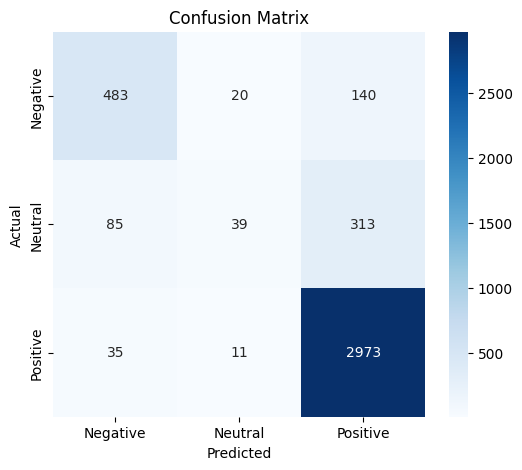

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
with open("final_ensemble_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Make predictions
y_pred = loaded_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Predict Sentiment for New Reviews

In [10]:
# Load the TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)

# Sample new reviews for testing
new_reviews = [
    "The hotel was amazing! I loved the service and the rooms were clean.",
    "Worst experience ever! The room was dirty, and staff was rude.",
    "It was an okay stay, nothing special but not bad either."
]

# Transform the new reviews using the TF-IDF vectorizer
new_reviews_tfidf = tfidf_vectorizer.transform(new_reviews)

# Predict sentiments using the trained model
new_predictions = loaded_model.predict(new_reviews_tfidf)

# Display results
for review, sentiment in zip(new_reviews, new_predictions):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: The hotel was amazing! I loved the service and the rooms were clean.
Predicted Sentiment: Positive

Review: Worst experience ever! The room was dirty, and staff was rude.
Predicted Sentiment: Negative

Review: It was an okay stay, nothing special but not bad either.
Predicted Sentiment: Negative



Save the Final Model and TF-IDF Vectorizer

In [11]:
import pickle

# Save the trained model
with open("final_ensemble_model.pkl", "wb") as file:
    pickle.dump(loaded_model, file)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf_vectorizer, file)

print("Final model and TF-IDF vectorizer saved successfully!")


Final model and TF-IDF vectorizer saved successfully!


To Load and Use the Model Again

In [12]:
import pickle

# Load the trained model
with open("final_ensemble_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Load the TF-IDF Vectorizer
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)

# Sample input review for testing
sample_review = ["The staff was really helpful and friendly, had a great time!"]

# Transform the review using TF-IDF
sample_tfidf = tfidf_vectorizer.transform(sample_review)

# Predict sentiment
predicted_sentiment = loaded_model.predict(sample_tfidf)

print("Predicted Sentiment:", predicted_sentiment[0])


Predicted Sentiment: Positive


Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
import pickle

# Define parameter grids
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
nb_params = {'alpha': [0.1, 0.5, 1.0]}

# Grid Search for SVM
svm = SVC(probability=True)  # Enable probability for soft voting
svm_grid = GridSearchCV(svm, svm_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
svm_grid.fit(X_train, y_train)

# Best SVM parameters
best_svm = svm_grid.best_estimator_
print("Best SVM Parameters:", svm_grid.best_params_)

# Grid Search for Naïve Bayes
nb = MultinomialNB()
nb_grid = GridSearchCV(nb, nb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
nb_grid.fit(X_train, y_train)

# Best Naïve Bayes parameters
best_nb = nb_grid.best_estimator_
print("Best Naïve Bayes Parameters:", nb_grid.best_params_)

# Train optimized VotingClassifier
ensemble_model = VotingClassifier(estimators=[('svm', best_svm), ('nb', best_nb)], voting='soft')
ensemble_model.fit(X_train, y_train)

# Save the optimized model
with open("optimized_ensemble_model.pkl", "wb") as file:
    pickle.dump(ensemble_model, file)

# Evaluate performance
y_pred = ensemble_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Optimized Ensemble Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Naïve Bayes Parameters: {'alpha': 0.1}
Optimized Ensemble Model Accuracy: 0.8570383020248841

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.78      0.79       643
     Neutral       0.51      0.12      0.20       437
    Positive       0.88      0.98      0.93      3019

    accuracy                           0.86      4099
   macro avg       0.73      0.63      0.64      4099
weighted avg       0.83      0.86      0.83      4099



In [15]:
# Sample test reviews
sample_reviews = [
    "The hotel was amazing! Great service and friendly staff.",
    "Worst experience ever. The room was dirty and smelled bad.",
    "It was okay, nothing special but not too bad either."
]

# Transform the reviews using the saved TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf_vectorizer = pickle.load(file)

sample_tfidf = tfidf_vectorizer.transform(sample_reviews)

# Predict sentiment
sample_predictions = optimized_model.predict(sample_tfidf)

# Display predictions
for review, sentiment in zip(sample_reviews, sample_predictions):
    print(f"Review: {review} -> Predicted Sentiment: {sentiment}")


Review: The hotel was amazing! Great service and friendly staff. -> Predicted Sentiment: Positive
Review: Worst experience ever. The room was dirty and smelled bad. -> Predicted Sentiment: Negative
Review: It was okay, nothing special but not too bad either. -> Predicted Sentiment: Neutral
